Dimensione Training Set: (333, 8)


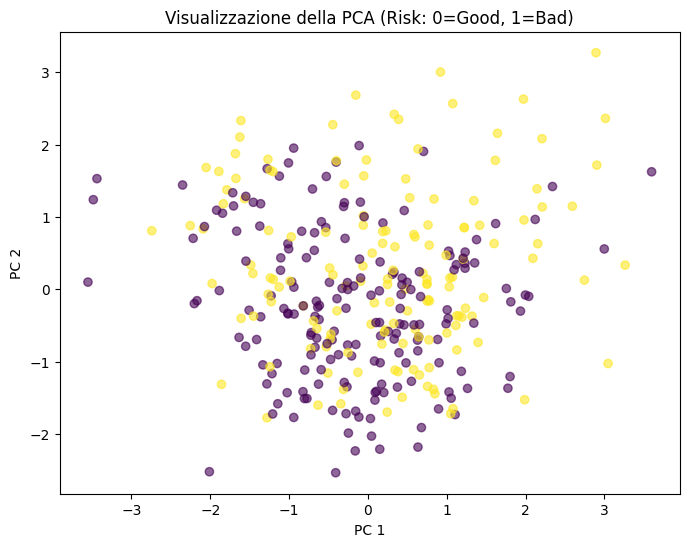

Componenti PCA mantenute per il 95% di varianza: 8

--- REGRESSIONE ---
Miglior parametro Ridge: {'alpha': 10.0}
Ridge Regression -> MSE: 5006497.8927, MAE: 1566.9515

--- CLASSIFICAZIONE ---
Training MLP
Best MLP Params: {'activation': 'tanh', 'hidden_layer_sizes': (100,)}
Training SVM
Best SVM Params: {'kernel': 'linear'}

Tabella di Confronto (Validation Set):
Modello    Accuracy   Precision  Recall     F1-Score  
MLP        0.5833     0.5312     0.4595     0.4928    
SVM        0.6548     0.7222     0.3514     0.4727    

Modello Selezionato per il Test finale: MLP

RISULTATI FINALI (TEST SET)
Report Test Set (MLP):
F1-Score: 0.4783
Accuracy: 0.5429
Precision: 0.4783
Recall:   0.4783

Tabella Speculativa (Test Set - Tutti i modelli):
Modello    Accuracy   Precision  Recall     F1-Score  
MLP        0.5429     0.4783     0.4783     0.4783    
SVM        0.6190     0.6154     0.3478     0.4444    


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, f1_score, accuracy_score, precision_score, recall_score

file_path = '/kaggle/input/german-credit-data-with-risk/german_credit_data.csv' #carico il dataset
df = pd.read_csv(file_path)

# STANDARDIZZAZIONE 

if 'Unnamed: 0' in df.columns: #rimuovo la colonna in cui ci sono i numeri delle righe (colonna 0 senza nome)
    df = df.drop(columns=['Unnamed: 0'])

df = df.dropna()#elimina le righe che hanno anche un una sola casella vuota

y_reg = df['Credit amount'] #variabile target per la regressione

y_cls = np.where(df['Risk'] == 'bad', 1, 0) #variabile target per la classificazione, dove la condizione è vera (bad), metti 1, altrimenti 0

X = df.drop(columns=['Credit amount', 'Risk']) #rimozione delle feature dalla matrice risultante

for col in X.columns: #scorre una per una tutte le colonne del dataset
    first_val = X[col].values[0] #prende la colonna col, la converte in un array(.values) e prende il primo elemento [0]
    
    if type(first_val) == str: # Se è testo
        elem_lista = [] #crea una lista vuota per memorizzare le parole 
        for val in X[col]: # Scorre tutte le righe della colonna corrente
            if val not in elem_lista: #se val non è già presente nella lista
                elem_lista.append(val) #lo aggiunge alla coda
    
        for i in range(len(elem_lista)): #vede quanti valori distinti abbiamo e genera un indice per ogni valore
            parola = elem_lista[i] #elemento in posizione i della lista
            numero = i #indice associato alla stringa
            
            X[col] = np.where(X[col] == parola, numero, X[col])# Sostituisce la parola con il numero corrispondente; #condizione, valore se vero, valore se falso
            
        X[col] = X[col].astype(int) # Converte in numeri interi

X_train_full, X_test, y_reg_train_full, y_reg_test, y_cls_train_full, y_cls_test = train_test_split( #stratify si assicura che quando dividiamo il dataset in train e test, la proporzione dei dati in y_cls rimanga invariata
    X, y_reg, y_cls, test_size=0.2, random_state=42, stratify=y_cls
     #random state utilizzato per la generazione di numeri pseudo-casuali, ci assicuriamo che gli stessi numeri casuali vengono generati ogni volda che eseguiamo il codice
)

X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val = train_test_split(
    X_train_full, y_reg_train_full, y_cls_train_full, test_size=0.2, random_state=42, stratify=y_cls_train_full
)

scaler_X = StandardScaler() #inizializzo un'oggetto
X_train_scaled_avg_ds = scaler_X.fit_transform(X_train) #faccio la media e la dev.std. e poi sottraggo la media e la divido per la dev.std
X_val_scaled_avg_dds = scaler_X.transform(X_val)
X_test_scaled_avg_dds = scaler_X.transform(X_test)

print(f"Dimensione Training Set: {X_train_scaled_avg_ds.shape}")

# RIDUZIONE DIMENSIONALITÀ
pca2d = PCA(n_components=2) #creo un'oggetto PCA con due componenti
X_train_trasformed = pca2d.fit_transform(X_train_scaled_avg_ds) #adatto la pca ai dati scalati

plt.figure(figsize=(8, 6))
#grafico a dispersione
scatter = plt.scatter(X_train_trasformed[:, 0], X_train_trasformed[:, 1], c=y_cls_train, cmap='viridis', alpha=0.6)#prende tutte le righe della prima colonna (PC1); prende tutte le righe della seconda colonna (PC2)
#c: (y_cls è una lista di numeri 0,1,0,1) da un colore a 0 e un'altro a 1
#cmap: la tavolozza dei colori vividi
#alpha: trasparenza
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Visualizzazione della PCA (Risk: 0=Good, 1=Bad)')
plt.show()

pca = PCA(n_components=0.95) #manteniamo un numero di componenti tali da poter spiegare almeno il 95% della varianza totale
X_train_pca = pca.fit_transform(X_train_scaled_avg_ds)
X_val_pca = pca.transform(X_val_scaled_avg_dds)
X_test_pca = pca.transform(X_test_scaled_avg_dds)

print(f"Componenti PCA mantenute per il 95% di varianza: {pca.n_components_}")

print("\n--- REGRESSIONE ---")

ridge = Ridge() #creazione dell'oggetto ridge che verrà poi ottimizzato
params_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]} #alpha sarebbe il lambda nella formula della regolarizzazione se 0 il termine regolarizzatore sparice, se 100 domina e i pesi devono essere piccolissimi
#gridsearch prova tutte le combinazioni
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_mean_squared_error') #utilizziamo la neg_mse perché la funzione GS è rpogettata per trovare il punteggio più alto e dato che mse è
# un errore, più basso è meglio è, il computer cerca il massimo ma noi vogliamo il minimo
grid_ridge.fit(X_train_pca, y_reg_train)

best_ridge = grid_ridge.best_estimator_
print(f"Miglior parametro Ridge: {grid_ridge.best_params_}")

y_pred_scaled = best_ridge.predict(X_test_pca)# Predizione sui dati scalati

mse_ridge = mean_squared_error(y_reg_test, y_pred_scaled)
mae_ridge = mean_absolute_error(y_reg_test, y_pred_scaled)

print(f"Ridge Regression -> MSE: {mse_ridge:.4f}, MAE: {mae_ridge:.4f}")

print("\n--- CLASSIFICAZIONE ---")

mlp = MLPClassifier(max_iter=2000, random_state=42)
params_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)], #uno strato con 50 hiden layer, uno strato con 100, due con 50
    'activation': ['relu', 'tanh']
}

print("Training MLP")
grid_mlp = GridSearchCV(mlp, params_mlp, cv=3, scoring='f1') # F1 sulla classe positiva (1=Bad) ci interessano i cattivi
grid_mlp.fit(X_train_pca, y_cls_train)
best_mlp = grid_mlp.best_estimator_
print(f"Best MLP Params: {grid_mlp.best_params_}")

svm = SVC(random_state=42)
params_svm = {
    'kernel': ['linear', 'rbf'] #controlla la forma del confine
     #linear = linea dritta 
     #rbf = linee curve/cerchi (gaussiano)
}

print("Training SVM")
grid_svm = GridSearchCV(svm, params_svm, cv=3, scoring='f1')
grid_svm.fit(X_train_pca, y_cls_train)
best_svm = grid_svm.best_estimator_
print(f"Best SVM Params: {grid_svm.best_params_}")

def get_metrics(model, X, y):
    pred = model.predict(X) #ritorna il vettore delle etichette di classe (0 o 1)
    return {
        'Accuracy': accuracy_score(y, pred),
        'Precision': precision_score(y, pred),
        'Recall': recall_score(y, pred),
        'F1-Score': f1_score(y, pred)
    }

metrics_mlp = get_metrics(best_mlp, X_val_pca, y_cls_val) #andranno a contenere tutte le metriche della funzione
metrics_svm = get_metrics(best_svm, X_val_pca, y_cls_val)

print("\nTabella di Confronto (Validation Set):")
print(f"{'Modello':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print(f"{'MLP':<10} {metrics_mlp['Accuracy']:<10.4f} {metrics_mlp['Precision']:<10.4f} {metrics_mlp['Recall']:<10.4f} {metrics_mlp['F1-Score']:<10.4f}")
print(f"{'SVM':<10} {metrics_svm['Accuracy']:<10.4f} {metrics_svm['Precision']:<10.4f} {metrics_svm['Recall']:<10.4f} {metrics_svm['F1-Score']:<10.4f}")

if metrics_mlp['F1-Score'] > metrics_svm['F1-Score']:
    final_model = best_mlp
    best_name = "MLP"
else:
    final_model = best_svm
    best_name = "SVM"

print(f"\nModello Selezionato per il Test finale: {best_name}")

print("\nRISULTATI FINALI (TEST SET)")
final_metrics = get_metrics(final_model, X_test_pca, y_cls_test)
print(f"Report Test Set ({best_name}):")
print(f"F1-Score: {final_metrics['F1-Score']:.4f}")
print(f"Accuracy: {final_metrics['Accuracy']:.4f}")
print(f"Precision: {final_metrics['Precision']:.4f}")
print(f"Recall:   {final_metrics['Recall']:.4f}")

print("\nTabella Speculativa (Test Set - Tutti i modelli):")
test_mlp = get_metrics(best_mlp, X_test_pca, y_cls_test)
test_svm = get_metrics(best_svm, X_test_pca, y_cls_test)
print(f"{'Modello':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print(f"{'MLP':<10} {test_mlp['Accuracy']:<10.4f} {test_mlp['Precision']:<10.4f} {test_mlp['Recall']:<10.4f} {test_mlp['F1-Score']:<10.4f}")
print(f"{'SVM':<10} {test_svm['Accuracy']:<10.4f} {test_svm['Precision']:<10.4f} {test_svm['Recall']:<10.4f} {test_svm['F1-Score']:<10.4f}")